Importación de librerías
En esta celda importo todas las librerías necesarias para el análisis.

pandas y numpy para manipulación de datos

matplotlib y seaborn para visualizaciones

CountVectorizer para convertir texto en números

train_test_split para dividir los datos en entrenamiento y prueba

modelos Naive Bayes y métricas

pickle para guardar el modelo final

Esta celda prepara todo el entorno de trabajo para el proyecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
sns.set(style="whitegrid")

2. Cargar dataset
Aquí cargo el archivo playstore_reviews.csv, que contiene las reseñas de usuarios.
Cada fila es una reseña y la columna polarity indica si el comentario es positivo (1) o negativo (0).
Luego visualizo las primeras filas para asegurarme de que se ha cargado correctamente.


In [3]:
# Opción 1: desde archivo local
df = pd.read_csv("../data/raw/playstore_reviews.csv")


df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


3. limpieza basica de los datos.

En esta celda realizo una limpieza básica del texto para facilitar el análisis:

Paso todos los comentarios a minúsculas

Elimino espacios sobrantes

Elimino la columna package_name, ya que no aporta información útil para predecir el sentimiento

Elimino filas con valores nulos en la columna review

Esto me deja los textos listos para el siguiente paso.

In [4]:
# Información general del dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


,polarity
count,891.000000
mean,0.344557
std,0.475490
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
# Pasar todo a minúsculas y quitar espacios a los lados
df["review"] = df["review"].astype(str).str.lower().str.strip()

# Eliminar filas con review nula
df = df.dropna(subset=["review"])

# Eliminar columna que no es predictora
if "package_name" in df.columns:
    df = df.drop("package_name", axis=1)

df.head()

,review,polarity
0,privacy at least put some option appear offlin...,0
1,"messenger issues ever since the last update, i...",0
2,profile any time my wife or anybody has more t...,0
3,the new features suck for those of us who don'...,0
4,forced reload on uploading pic on replying com...,0


In [6]:
df.head()
df.columns

Index(['review', 'polarity'], dtype='object')

In [7]:
X = df["review"]       # columna de textos
y = df["polarity"]     # etiquetas

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# vectirizacion

vectorizer = CountVectorizer(stop_words="english")

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

4. EDA: información genera

Aqui exploro la estructura del dataset:
-Tipos de datos
-Valores nulos
-Cantidad de muestras
-Primeras estadisticas descriptivas
(esto me ayuda para entender como estan distribuidas las variables antes del moldeado).


In [9]:
print("Información del DataFrame:")
print(df.info())
print("\nDescripción de variables numéricas:")
print(df.describe(include="all"))

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    891 non-null    object
 1   polarity  891 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.1+ KB
None

Descripción de variables numéricas:
                                                   review    polarity
count                                                 891  891.000000
unique                                                890         NaN
top     this update sucks!!! i can't open the game any...         NaN
freq                                                    2         NaN
mean                                                  NaN    0.344557
std                                                   NaN    0.475490
min                                                   NaN    0.000000
25%                                                   NaN    0.0

In [10]:
# Revisar nulos
df.isnull().sum()

review      0
polarity    0
dtype: int64

No hay nulos

5. Distribucion de la variable objetivo
En esta celda visualizo como estan distribuidos los valores de  `polarity´(positivo vs.negativo).
Es importante saber si el dataset esta balanceado o si hay mas comentarios positivos quenegativos. 
Esto afecta al rendimiento del modelo.


Esto es importante para saber si el dataset está balanceado.

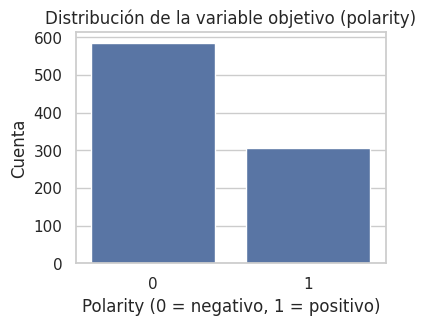

polarity
0    0.655443
1    0.344557
Name: proportion, dtype: float64

In [11]:
plt.figure(figsize=(4,3))
sns.countplot(x="polarity", data=df)
plt.title("Distribución de la variable objetivo (polarity)")
plt.xlabel("Polarity (0 = negativo, 1 = positivo)")
plt.ylabel("Cuenta")
plt.show()

df["polarity"].value_counts(normalize=True)

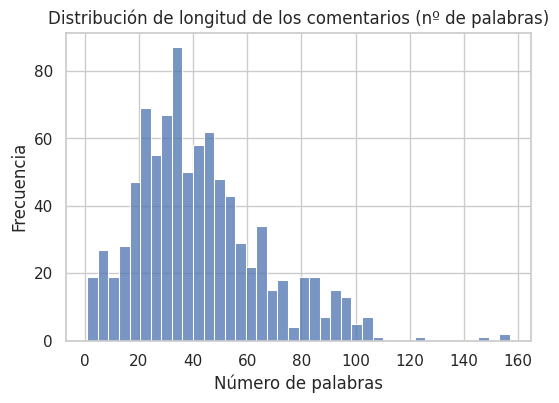

count    891.000000
mean      42.481481
std       23.835401
min        1.000000
25%       26.000000
50%       39.000000
75%       54.500000
max      157.000000
Name: word_count, dtype: float64

In [12]:
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(6,4))
sns.histplot(df["word_count"], bins=40)
plt.title("Distribución de longitud de los comentarios (nº de palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

df["word_count"].describe()

6. Longitud de los comentarios
Aqui calculo cuantas palabras tiene cada comentario y visualizo la distribucion.
Este analisis permite ver si hay comentarios demasiado cortos o largos , y etender mejor la estructura del texto.

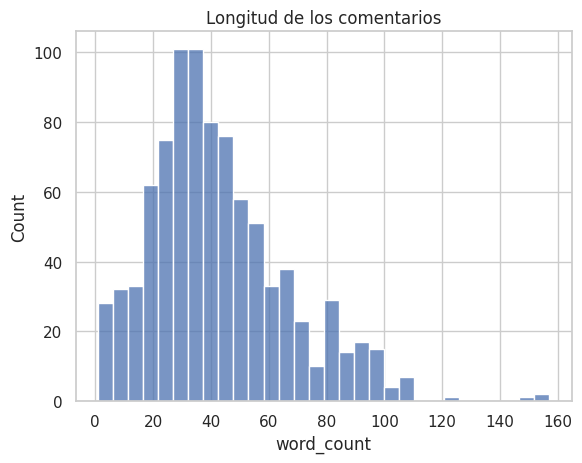

In [13]:
# Número de palabras por review
df["word_count"] = df["review"].apply(lambda x: len(str(x).split()))

sns.histplot(df["word_count"], bins=30)
plt.title("Longitud de los comentarios")
plt.show()

7. PALABRAS MAS FRECUENTES 
En esta celda identifico las palabras que mas se repiten en todas las reseñas.
Utilizo `CountVectirizer´para convertir los textos en una matriz numerica y luego cuento las palabras mas comunes.
Esto ayuda a detectar temas mas freucentes en las reseñas.



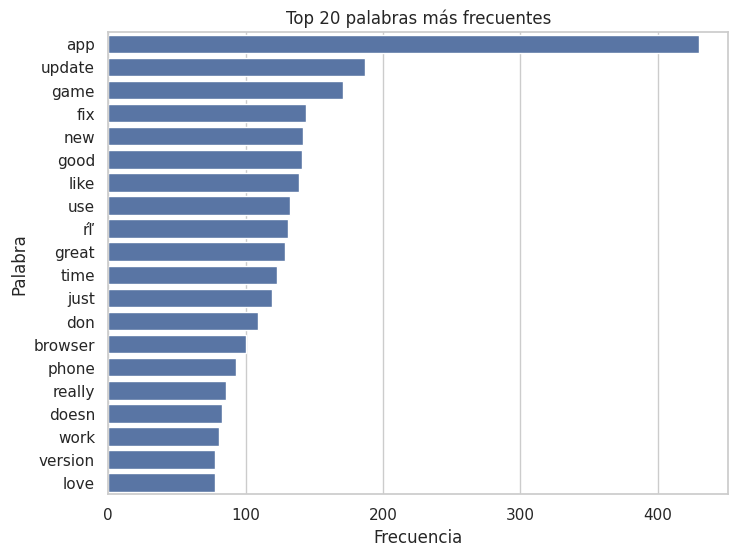

[('app', 430),
 ('update', 187),
 ('game', 171),
 ('fix', 144),
 ('new', 142),
 ('good', 141),
 ('like', 139),
 ('use', 132),
 ('ŕľ', 131),
 ('great', 129),
 ('time', 123),
 ('just', 119),
 ('don', 109),
 ('browser', 100),
 ('phone', 93),
 ('really', 86),
 ('doesn', 83),
 ('work', 81),
 ('version', 78),
 ('love', 78)]

In [14]:
# Palabras más frecuentes
# Antes hay que limpiar texto:


vectorizer_eda = CountVectorizer(stop_words="english")
X_eda = vectorizer_eda.fit_transform(df["review"])

sum_words = X_eda.sum(axis=0)

words_freq = [
    (word, int(sum_words[0, idx]))
    for word, idx in vectorizer_eda.vocabulary_.items()
]

words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_n = 20
top_words = words_freq[:top_n]

words = [w[0] for w in top_words]
counts = [w[1] for w in top_words]

plt.figure(figsize=(8,6))
sns.barplot(x=counts, y=words)
plt.title(f"Top {top_n} palabras más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

top_words

8.Palabras frecuentes en positivos vs negativos

En esta parte separo las reseñas positivas y negativas ,calculo las palabras mas utilizadas  en cada grupo.
Esto permite identificar que terminos aparecen mas en comentarios negativos (quejas, problemas) y cuales en positivos (elogios,satisfaccion).
Es muy util para interpretar los patrones del dataset.


In [15]:
df_pos = df[df["polarity"] == 1]
df_neg = df[df["polarity"] == 0]

# Positivas
vec_pos = CountVectorizer(stop_words="english")
X_pos = vec_pos.fit_transform(df_pos["review"])
sum_pos = X_pos.sum(axis=0)
words_pos = [
    (word, int(sum_pos[0, idx]))
    for word, idx in vec_pos.vocabulary_.items()
]
words_pos = sorted(words_pos, key=lambda x: x[1], reverse=True)[:15]

# Negativas
vec_neg = CountVectorizer(stop_words="english")
X_neg = vec_neg.fit_transform(df_neg["review"])
sum_neg = X_neg.sum(axis=0)
words_neg = [
    (word, int(sum_neg[0, idx]))
    for word, idx in vec_neg.vocabulary_.items()
]
words_neg = sorted(words_neg, key=lambda x: x[1], reverse=True)[:15]

print("Top palabras en reseñas POSITIVAS:")
for w, c in words_pos:
    print(f"{w}: {c}")

print("\nTop palabras en reseñas NEGATIVAS:")
for w, c in words_neg:
    print(f"{w}: {c}")

Top palabras en reseñas POSITIVAS:
app: 157
ŕľ: 114
game: 91
great: 87
good: 71
love: 56
like: 53
žŕ: 52
use: 47
best: 45
browser: 42
really: 39
just: 38
new: 29
apps: 28

Top palabras en reseñas NEGATIVAS:
app: 273
update: 164
fix: 130
new: 113
time: 99
like: 86
don: 85
use: 85
just: 81
game: 80
doesn: 78
phone: 76
good: 70
version: 65
google: 65


In [16]:
X = df["review"]
y = df["polarity"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)

(712, 179)

In [17]:
# vectorizacion
vectorizer = CountVectorizer(stop_words="english")

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((712, 3272), (179, 3272))

In [18]:
# probar los tres de Naive Bayes
models = {
    "MultinomialNB": MultinomialNB(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB()
}

results = {}

for name, clf in models.items():
    print("="*60)
    print(f"Modelo: {name}")
    
    # Algunos modelos necesitan array denso
    if name in ["GaussianNB", "BernoulliNB"]:
        clf.fit(X_train_vec.toarray(), y_train)
        y_pred = clf.predict(X_test_vec.toarray())
    else:
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))

Modelo: MultinomialNB
Accuracy: 0.8547

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       117
           1       0.89      0.66      0.76        62

    accuracy                           0.85       179
   macro avg       0.87      0.81      0.83       179
weighted avg       0.86      0.85      0.85       179

Modelo: GaussianNB
Accuracy: 0.8156

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       117
           1       0.76      0.68      0.72        62

    accuracy                           0.82       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.81      0.82      0.81       179

Modelo: BernoulliNB
Accuracy: 0.7821

Classification report:

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       117
           1       0.87      0.44      0.58       

In [19]:
# probar los tres de Naive Bayes
models = {
    "MultinomialNB": MultinomialNB(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB()
}

results = {}

for name, clf in models.items():
    print("="*60)
    print(f"Modelo: {name}")
    
    # Algunos modelos necesitan array denso
    if name in ["GaussianNB", "BernoulliNB"]:
        clf.fit(X_train_vec.toarray(), y_train)
        y_pred = clf.predict(X_test_vec.toarray())
    else:
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))

Modelo: MultinomialNB
Accuracy: 0.8547

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       117
           1       0.89      0.66      0.76        62

    accuracy                           0.85       179
   macro avg       0.87      0.81      0.83       179
weighted avg       0.86      0.85      0.85       179

Modelo: GaussianNB
Accuracy: 0.8156

Classification report:

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       117
           1       0.76      0.68      0.72        62

    accuracy                           0.82       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.81      0.82      0.81       179

Modelo: BernoulliNB


Accuracy: 0.7821

Classification report:

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       117
           1       0.87      0.44      0.58        62

    accuracy                           0.78       179
   macro avg       0.82      0.70      0.72       179
weighted avg       0.80      0.78      0.76       179



In [20]:
# ver cual fue mejor
results
best_model_name = max(results, key=results.get)
best_model_name

'MultinomialNB'

In [21]:
# Random Forest para comprobar
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest:", acc_rf)
print("\nClassification report RF:\n")
print(classification_report(y_test, y_pred_rf))

Accuracy Random Forest: 0.8212290502793296

Classification report RF:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       117
           1       0.79      0.66      0.72        62

    accuracy                           0.82       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.82      0.82      0.82       179



In [22]:
# entrenar de nuevo Naives Bayers y guardarlo
# Por si quieres asegurarte de que usas MultinomialNB
final_model = MultinomialNB()
final_model.fit(X_train_vec, y_train)

# Guardar modelo y vectorizador
with open("modelo_naive_bayes.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Modelo y vectorizador guardados correctamente.")

Modelo y vectorizador guardados correctamente.


In [23]:
# probar los textos con nuevos textos
ejemplos = [
    "this app is amazing, very useful and easy to use",
    "terrible experience, full of bugs and crashes all the time",
    "i love this app",
    "worst update ever"
]

ejemplos_vec = vectorizer.transform(ejemplos)
pred = final_model.predict(ejemplos_vec)

for texto, etiqueta in zip(ejemplos, pred):
    print(f"Texto: {texto}")
    print(f"Predicción (0=neg,1=pos): {etiqueta}")
    print("-"*50)

Texto: this app is amazing, very useful and easy to use
Predicción (0=neg,1=pos): 1
--------------------------------------------------
Texto: terrible experience, full of bugs and crashes all the time
Predicción (0=neg,1=pos): 0
--------------------------------------------------
Texto: i love this app
Predicción (0=neg,1=pos): 1
--------------------------------------------------
Texto: worst update ever
Predicción (0=neg,1=pos): 0
--------------------------------------------------


En este ejercicio he trabajado con el dataset de playstore_reviews.csv para analizar las reseñas y clasificarlas entre positivas y negativas. Después de cargar y revisar los datos, utilicé CountVectorizer para transformar los textos y entrené un modelo de Naive Bayes, que funciona bastante bien para este tipo de problemas de análisis de sentimientos.

También separé las reseñas según su polaridad y analicé las palabras más frecuentes en las positivas y en las negativas. Esto me ayudó a ver los patrones de lenguaje que usa la gente dependiendo de si la opinión es buena o mala.

En general, el proceso me ha servido para entender mejor cómo funcionan los modelos de clasificación de texto y cómo preparar los datos antes de entrenarlos. Es un enfoque sencillo, pero efectivo, y me ha permitido ver de manera clara cómo se diferencian las reseñas positivas de las negativas.